In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib qt
%matplotlib inline

In [2]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [3]:
src = np.float32([
    [755,470],
    [1100,675],
    [300,680],
    [600,470]])
dest = np.float32([
    [1160,0],
    [1160,720],
    [260,720],
    [260,0]])

In [4]:
# define the corner in chess
obj = np.zeros((9*6, 3), np.float32)
obj[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
nx = 9
ny = 6

In [ ]:
# read all the images
images = glob.glob('camera_cal/calibration*.jpg')

objPoints = []
imgPoints = []

#itrate through image

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    if ret == True:
        objPoints.append(obj)
        imgPoints.append(corners)


In [ ]:
# colibrate the camera 
img = cv2.imread('camera_cal/calibration1.jpg')
imgshape = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( objPoints, imgPoints, imgshape, None, None)

#restore the value, for later uses
disk_pickle = {}
disk_pickle['dist'] = dist
disk_pickle['mtx'] = mtx
pickle.dump(disk_pickle, open("calibration_wide/wide_dist_pickle.p","wb"))

In [5]:
# load the data back to data
import pickle
data = pickle.load( open("calibration_wide/wide_dist_pickle.p","rb"))
mtx = data['mtx']
dist = data['dist']

In [6]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def perspecive(img):
    imgshape = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src,dest)
    Minv = cv2.getPerspectiveTransform(dest,src)
    wraped = cv2.warpPerspective(img, M, imgshape, flags=cv2.INTER_LINEAR )
    return M, Minv, wraped

In [7]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

In [8]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        last_all_x = None
        last_all_x = None

In [9]:
def laneLines(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    detected = True
    if not list(leftx) or not list(lefty):
        leftx = line_lt.last_all_x
        lefty = line_lt.last_all_y
        detected = False
    
    if not list(rightx) or not list(righty):
        rightx = line_rt.last_all_x
        righty = line_rt.last_all_y
        detected = False
        
    line_lt.last_all_x = leftx
    line_lt.last_all_y = lefty
    line_lt.detected = detected
    
    line_rt.last_all_x = rightx
    line_rt.last_all_y = righty
    line_rt.detected = detected
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx

In [10]:
def curvature(left_fit, right_fit, leftx, rightx):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#     # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Example values: 1926.74 1908.48
    # Fit new polynomials to x,y in world space
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, ploty

In [11]:
# Create an image to draw the lines on
def final_result(warped, undistort, Minv, left_fitx, right_fitx, ploty):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warp_zero.shape[1], warp_zero.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
    return result

In [12]:
def process_image(img):
    undist = undistort(img)
    binary = pipeline(undist)
    M, Minv, warped = perspecive(binary)
    warped = warped[:,:,2]
    left_fit, right_fit, leftx, rightx,  = laneLines(warped)
    leftcurve, rightcurve, ploty = curvature(left_fit, right_fit, leftx, rightx)
    result = final_result(warped, undist, Minv, leftx, rightx, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int((leftcurve+rightcurve)/2))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    return result

640.0


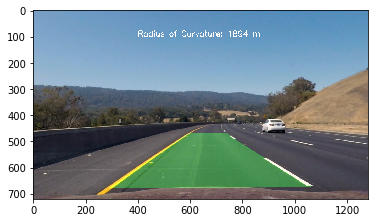

In [14]:
img = mpimg.imread('test3.jpg')
line_lt = Line()
line_rt = Line()
laneWithLine = process_image(img)
plt.imshow(laneWithLine)
print(laneWithLine.shape[1]/2)

In [13]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections
# Set up lines for left and right
line_lt = Line()
line_rt = Line()
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:04<00:00,  4.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4min 6s
